<a href="https://colab.research.google.com/github/lalit-jamdagnee/Learning-Neural-Network-and-Deep-Learning/blob/main/02_Training_Deep_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To tackle complex problems, such as detecting hundreds of types of objects in high-resolution images,etc., we will need to train much deeper DNN, perhaps with 10 layers or more, each containing hundreds of neuron, linked with hundred of thousands of connections. Training a deep DNN isn't a piece of a cake. Here are some of the problems you might run into:

* Tricky *vanishing gradients* or *exploding gradients* problem.

* Insufficient training data.

* Training maybe extremely slow.

* Risk of overfitting.

In this chapter, we will go through each of these problems and see techniques to solve them. After which we will be able to train very depp nets.

Welcome to Deep Learning!

# The Vanishing/Exploding Gradients Problems

Backpropagation algorithm goes from the output layer to the input layer, propagating the error gradient side by side. Once the algorithm has computed the gradient of the cost function with regard to each parameter in the network, it uses these gradients to update each parameter with a Gradient Descent step.

Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, The Gradient Descent update leaves the lower layer's connection weights virtually unchanged, and training never converges to a good solution. We call this the **vanishing gradients** problem.

In some cases, the opposite can happen: the gradient can grow bigger and bigger until layer get insanely large weight updates and algorithm diverges. This is called **exploding gradients** problem, which surfaces in Recurrent Neural Network.

More generally, deep neural network suffer from unstable gradients; different layers may learn at widely different speeds.

The research shows that its mainly due to logistic sigmoid activation function and the weight initialization technique (i.e., a normal distribution with a mean of 0 and a standard deviation of 1).

 ## Glorot and He Initilaization

In their paper, **Xavier Glorot** and **Yoshua Bengio** propose a way to significantly alleviate the unstable gradients problem. They point out that we need the signal flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients. We don't want the signal to die out, nor do we want it explode and saturate. For the signal to flow properly, the authors argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we need the gradients to have equal variance before and after flowign through a layer in the reverse direction.

It is actually not possible to guarantee both unless the layer has an equal number of inputs neurons (these number are called the *fan-in* and *fan-out* of the layer), but Glorot and Bengio proposed a good compromise that has proven to work very well in practice: **The connection weights of each layers must be initialized randomnly**, as described in the equation below. This initialization strategy is called **Xavier initialization** or **Glorot initialization**, after the paper's first author.

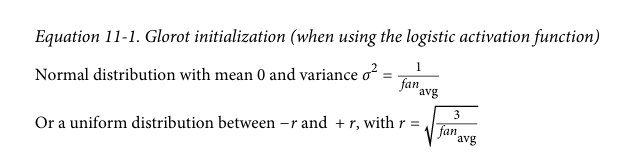

Some papers have provided similar strategies for different activation functions. These strategies differ only by the scale of the variance and whether they use fan-avg or fan-in, as show below:

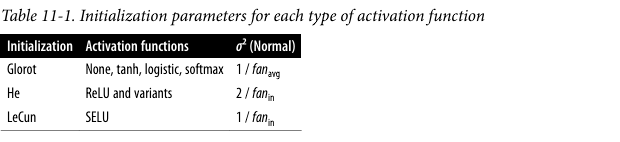

The initialization strategy for the ReLU activation function is called **He initialization**, after the paper's first author. And for the SELU activation function it's called as **LeCun initialization**.


By default, Keras uses Glorot initialization with a uniform distribution. When creating a layer, you can change this to He initialization by setting **kernel_initializer = "he_uniform" or "he_normal"** like this:

In [ ]:
import tensorflow as tf
tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')

<Dense name=dense, built=False>

If you want He initialization with a uniform distribution but based on **fan-avg** rather than **fan-in** you can use the **VarianceScaling** initializer like this:

In [ ]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                                    distribution='uniform')
tf.keras.layers.Dense(10, activation='relu', kernel_initializer=he_avg_init)

<Dense name=dense_1, built=False>

## Nonsaturating Activation Functions

One of the insights in the 2010 paper by Glorot and Bengio was that the problems with unstable gradients were in part due to a poor choice of activation function. But it turns out that other activation function, in particular ReLU activation function behave much better in deep NN.

Unfortunately, the ReLU activation is not perfect. It suffers from a problem known as the *dying ReLUs*: during training, some neurons effectively "die", meaning they stop outputting anything other than 0. A neuron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set. When this happens, it just keeps outputting zero, and Gradient Descent does not affect it anymore because the gradient of the ReLU function is zero when the input is negative.

To solve this problem, we can use a variant of ReLU function, such as the *leaky ReLU*. This function is defined as LeakyReLU(z) = max(ɑz, z), see the figure below. THe hyperparameter ɑ defines how much the function "leaks": it is the slope of the function for z < 0 and is typically set to 0.01.

There is another variation called *randomized leaky ReLU (RReLU)*, where ɑ is picked randomly in a given range during the training and fixed to an average during testing. After research it was found that leaky ReLU outperforms the ReLU function and its other variants.

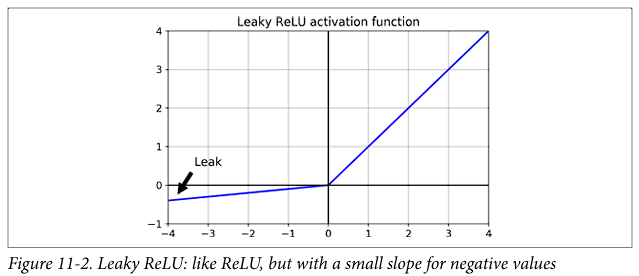

Lastly in 2015, a paper by Djork et al. proposed a new activation function called the **exponential linear unit** (ELU) that outperformed all the ReLU variants, training time was reduced, and the neural network performed better on the test set. Below are the equation and graph for the ELU function:

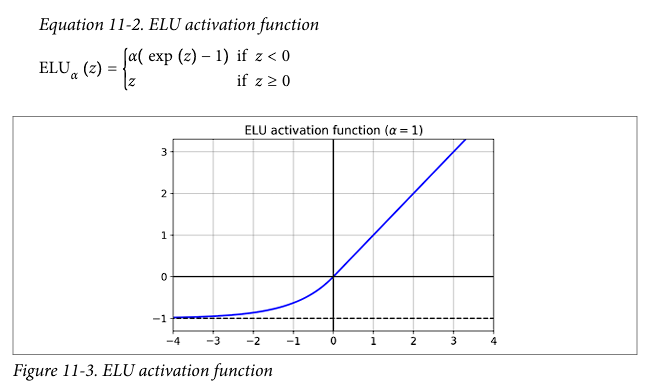

The main drawback of the ELU activation function is that it is slower to compute than the ReLU function and its variants (due to the use of the exponential function). Its faster convergence rate during training compensates for that slow computation, but still, at test time an ELU network will be slower than a ReLU network.

Then in a paper in 2017 the **Scaled ELU (SELU)** activation function was introduced, it is scaled variant of the ELU activation function. The paper showed that if you build a neural network composed of dense layers, and if all hidden layers use the SELU activation function, then the network will *self-normalize*: the output of each layer will tend to preserve a mean of 0 and standard deviation of 1 during training, which solves the problem of *vanishing/exploding Gradients*. As a result, the SELU activation function often significantly outperforms other activation functions for such Deep NN. There are however, few conditions for self-normalization to happen:

* The input features must be standardized (mean 0 and standard deviation 1).

* Every hidden layer's weights must be initialized with **LeCun normal** initialization.

* The network's architecture must be sequential.

* All the layers must be dense.

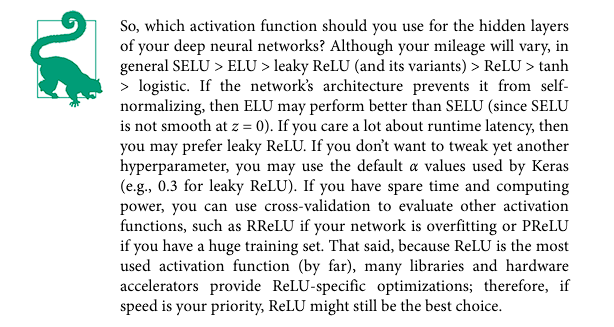

To use leakky ReLU activation function, create a **LeakyReLU** layer and add it to your model just after the layer you want to apply it to:

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(10, kernel_initializer='he_normal'))
model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


For SELU activation, set **activation = 'selu'** and **kernel_initializer='lecun_normal'** when creating layer.

In [ ]:
layer = tf.keras.layers.Dense(10, activation='selu', kernel_initializer='lecun_normal')

## Batch Normalization

Although using He initialization along with ELU (or any variant of ReLU) can significantly reduce the danger of the vanishing/exploding gradients problems at the beginning of the training, it doesn't guarantee that theywon't come back during training.

There is a technique called **Batch Normalization (BN)** that addresses these problems. The technique consists of adding an operation in the model just before or after the activation function of each hidden layer. This operation simply zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling and the other for shifting.

In other words, the operation lets model learn the optimal scale and mean of each of the layer's inputs. In many cases, if you add a BN layer as the very first layer of your neural network, you do not need to standardize your training set (e.g., using a **StandardScalar**); the BN layer will do it for you. In order to zero-center and normalize the inputs, the algorithm needs to estimate each input's mean standard deviation.

Research shows that Batch Normalization considerably improved all the deep neural networks they experimented with leading to huge improvement  in the ImageNet classification task (ImageNet is a large dataabase of images classified into many classes, commonly used to evaluate computer vision systems). The vanishing gradients problem was strongly reduced, to the p oint that they could use saturating activation functions such as the tanh and even the logistic activation function. The networks were also much less sensitives to the weight initialization.

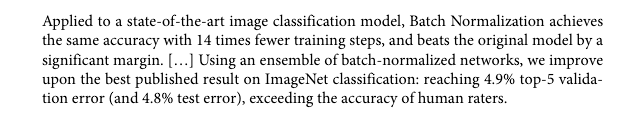

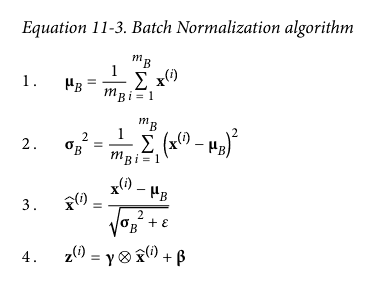

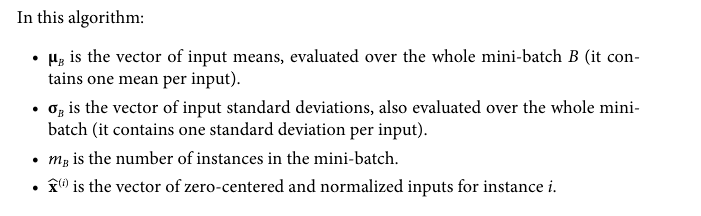

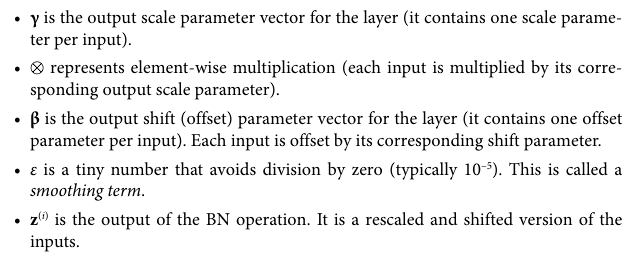

Batch Normalization also acts like a regularizer, reducing the need for other regularization techniques such as dropout.

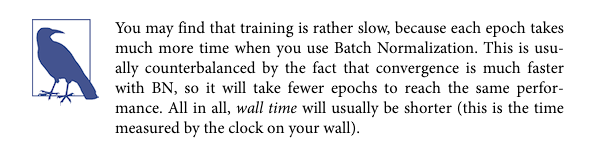

### Implementing Batch Normalization with Keras

Implementing Batch Normalization is simple and intuitive with Keras. Just add a **BatchNormalization** layer before or after each hidden layer's activation function. For example, this model applies BN after every hidden layer and as the first layer in the m odel (after flattening the input images):

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


That's all! In this tiny example with just two hidden layers, it's unlikely that Batch NOrmalizatoin will have a very positive impact; but for deeper networks it can make a tremendous difference.

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 784)                 │           3,136 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 300)                 │           1,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 271,346 (1.04 MB)

 Trainable params: 268,978 (1.03 MB)

 Non-trainable params: 2,368 (9.25 KB)

As you can see, each BN layer adds four parameter per input: ʏ, μ, β and σ (for example, the first BN layer adds 3,136 parameter, which is 4 x 784). The last two parameters, μ and σ, are the moving averages; they are not affected by backpropagation, so Keras calls them "non-trainable". If you count the total number of BN parameters, 3136 + 1,200 + 400 and divide by 2, you get 2368, which is the total number of non-trainable parameters in this model.

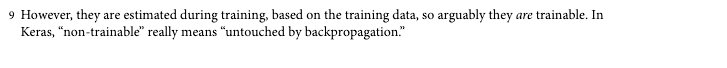

In [ ]:
# Let's look at the parameters of the first BN layer. Two are trainable
# two are not

[(var.name, var.trainable) for var in model.layers[1].variables]

[('gamma', True),
 ('beta', True),
 ('moving_mean', False),
 ('moving_variance', False)]

The authors of the BN paper argued in favor of adding the BN layers before the activation functions, rather than after. There is some debate about this,as which is preferable depends on the task. To add the BN layers before the activation functions, you must remove the activation function from the hidden layers and add them as separate layers after the BN layers. Moreover, since a Batch Normalization layer includes one offset parameter per input, you can remove bias term from the previous layer (just pass **use_bias=False** when creating it):

In [ ]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, kernel_initializer='he_normal', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('elu'),
    tf.keras.layers.Dense(100, kernel_initializer='he_normal', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('elu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

The BatchNormalization class has quite a few hyperparameters you can tweak. The
 defaults will usually be fine, but you may occasionally need to tweak the momentum.
 This hyperparameter is used by the BatchNormalization layer when it updates the
 exponential moving averages; given a new value v (i.e., a new vector of input means
 or standard deviations computed over the current batch), the layer updates the running average v^
 using the following equation:

 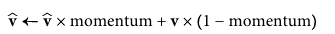

 Another important hyperparameter is axis: it determines which axis should be nor
malized. It defaults to –1, meaning that by default it will normalize the last axis (using
 the means and standard deviations computed across the other axes). When the input
 batch is 2D (i.e., the batch shape is [batch size, features]), this means that each input
 feature will be normalized based on the mean and standard deviation computed
 across all the instances in the batch. For example, the first BN layer in the previous
 code example will independently normalize (and rescale and shift) each of the 784
 input features. If we move the first BN layer before the Flatten layer, then the input
 batches will be 3D, with shape [batch size, height, width]; therefore, the BN layer will
 compute 28 means and 28 standard deviations (1 per column of pixels, computed
 across all instances in the batch and across all rows in the column), and it will nor
malize all pixels in a given column using the same mean and standard deviation.
 There will also be just 28 scale parameters and 28 shift parameters. If instead you still
 want to treat each of the 784 pixels independently, then you should set axis=[1, 2].

**BatchNormalization** has become one of the most-used layers in deep neural networks, to the point that it is often omitted in the diagrams, as it is assumed that BN is added after every layers.

## Gradient Clipping

Another popular technique to mitigate the exploding gradients problem is to clip the gradients during the backpropagation so that they never exceed some threshold. This is called **Gradient Clipping**.

In keras, implementing Gradient Clipping is just a matter of setting the **clipvalue** or **cipnorm** argument when creating an optimizer, like this:

In [ ]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss='mse', optimizer=optimizer)

 This optimizer will clip every component of the gradient vector to a value between–1.0 and 1.0. This means that all the partial derivatives of the loss (with regard to each
 and every trainable parameter) will be clipped between –1.0 and 1.0. The threshold is
 a hyperparameter you can tune. Note that it may change the orientation of the gradi
ent vector. For instance, if the original gradient vector is [0.9, 100.0], it points mostly
 in the direction of the second axis; but once you clip it by value, you get [0.9, 1.0],
 which points roughly in the diagonal between the two axes. In practice, this approach
 works well. If you want to ensure that Gradient Clipping does not change the direc
tion of the gradient vector, you should clip by norm by setting clipnorm instead of
 clipvalue. This will clip the whole gradient if its ℓ2
 norm is greater than the thres
hold you picked. For example, if you set clipnorm=1.0, then the vector [0.9, 100.0]
 will be clipped to [0.00899964, 0.9999595], preserving its orientation but almost elim
inating the first component. If you observe that the gradients explode during training
 (you can track the size of the gradients using TensorBoard), you may want to try both
 clipping by value and clipping by norm, with different thresholds, and see which
 option performs best on the validation set

# Reusing Pretrained Layers

It is generally not a good idea to train a very large DNN from scratch: instead, you should always try fo find an existing neural network that accommplishes a similar task to the one your are trying to tackle, then reuse the lower layers of this network. This technique is called **transfer learning**. It will not only speed up training considerably but also requires significantly less training data.

Suppose you have access to a DNN that was trained to classify pictures into 100 different categories, including animals, plants vehicles, and everyday objects. You now want to train a DNN to classify specific types of vehicles. These tasks are very similar even partly overlapping, so you should try to reuse parts of the first network.

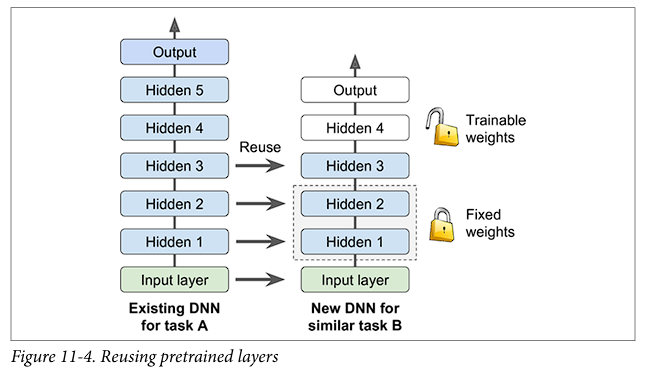

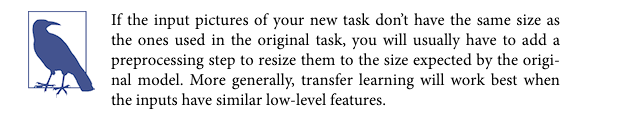

The output layer of the original model should usually be replaced beause it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task.

Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. You want to find the right number of layers to reuse.

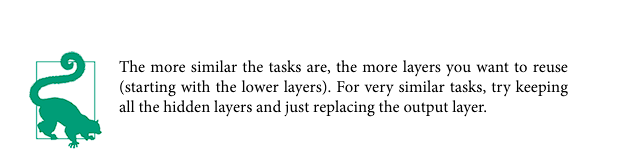

Try freezing all the reused layers first (i.e., make their weights non-trainable so that Gradient Descent won't modify them), then train your model and see how it performs. Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves. The more training data you have, the more layers you can unfreeze. It is also useful to reduce the learning rate when you unfreeze the reused layers, this will avoid wrecking their fine-tuned weights.

 If you still cannot get good performance, and you have little training data, try drop
ping the top hidden layer(s) and freezing all the remaining hidden layers again. You
 can iterate until you find the right number of layers to reuse. If you have plenty of
 training data, you may try replacing the top hidden layers instead of dropping them,
 and even adding more hidden layers.

## Transfer Learning with Keras

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
print(X_train_full.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [ ]:
import numpy as np

# Get the index of labels with classes 8 and 9

idx1 = np.where(y_train_full == 8)
temp = np.where(y_train_full == 9)

idx1 = np.concatenate((idx1[0], temp[0]), axis=0) # concat two array

X_train_B = X_train_full[idx1]
y_train_B = y_train_full[idx1]

print(X_train_B.shape, y_train_B.shape)

(12000, 28, 28) (12000,)


In [ ]:
# similarly to the test set

idx2 = np.where(y_test == 8)
temp = np.where(y_test == 9)

idx2 = np.concatenate((idx2[0], temp[0]), axis=0)
X_test_B = X_test[idx2]
y_test_B = y_test[idx2]

print(X_test_B.shape, y_test_B.shape)

(2000, 28, 28) (2000,)


In [ ]:
# Delete the rows from the original dataset
X_train_full = np.delete(X_train_full, idx1, axis=0)
y_train_full = np.delete(y_train_full, idx1, axis=0)

print(X_train_full.shape, y_train_full.shape)

(48000, 28, 28) (48000,)


In [ ]:
# Delete the rows from the test dataset
X_test = np.delete(X_test, idx2, axis=0)
y_test = np.delete(y_test, idx2, axis=0)

print(X_test.shape, y_test.shape)

(8000, 28, 28) (8000,)


In [ ]:
# split the new dataset into validation and training set

X_valid = X_train_full[:5000]/255.0
X_train = X_train_full[5000:]/255.0
y_valid = y_train_full[:5000]
y_train = y_train_full[5000:]
X_test = X_test/255.0

In [ ]:
X_train_B = X_train_B/255.0
X_test_B = X_test_B/255.0

In [ ]:
# Label for the classes
label = ['Tshirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneakers', 'Bag', 'Ankle Boot']


In [ ]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28,28]))
model_A.add(keras.layers.Dense(300, activation='relu'))
model_A.add(keras.layers.Dense(100, activation='relu'))
model_A.add(keras.layers.Dense(8, activation='softmax'))

In [ ]:
model_A.compile(loss='sparse_categorical_crossentropy',
                optimizer = 'SGD',
                metrics = ['accuracy'])

In [ ]:
history = model_A.fit(X_train, y_train, epochs=20,
                      validation_data=[X_valid, y_valid])

Epoch 1/20
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6709 - loss: 1.0117 - val_accuracy: 0.7788 - val_loss: 0.5981
Epoch 2/20
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8098 - loss: 0.5304 - val_accuracy: 0.8272 - val_loss: 0.4850
Epoch 3/20
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8293 - loss: 0.4721 - val_accuracy: 0.8190 - val_loss: 0.4891
Epoch 4/20
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8411 - loss: 0.4423 - val_accuracy: 0.8440 - val_loss: 0.4350
Epoch 5/20
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8444 - loss: 0.4287 - val_accuracy: 0.8380 - val_loss: 0.4410
Epoch 6/20
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8529 - loss: 0.4031 - val_accuracy: 0.8538 - val_loss: 0.3987
Epoch 7/20
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8575 - loss: 0.3960 - val_accuracy: 0.8564 - val_loss: 0.4056
Epoch 8/20
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8618 - loss: 0.3815

In [ ]:
model_A.evaluate(X_test, y_test)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8685 - loss: 0.3603


[0.3619106411933899, 0.8673750162124634]

Let's look at an example. Suppose if we train the MNIST dataset only on eight classes as you can see above- all classes except Bag and Ankle boot. And we got a reasonably good performance.

Let's call this model A. We now want to tackle a different task: we have the images of Bag & Ankle boot, and want to train a binary classifer (positive=Bag, negative = sandal).

Now let's use transfer learning to help out with this problem

First, we create the new model based on the model_A's layers. Then reuse all the layers except for the output layer

```
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))
```

Since the **model_A** and **model_B_on_A** now share some layers. When you train **model_B_on_A**, it will also effect **model_A*.

If you want to avoid that, you need to **clone model_A** before you reuse its layers. To do this, you clone model_A's architecture with **clone_model()**, then copy it's weights (since *clone_model()* does not clone te weights):

In [ ]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [ ]:
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

Now you could train **model_B_on_A** for task B, but since the new output layer was initialized randomly it will make large errors (at leasts during the first few epochs), so there will be large error gradients that may wreck the reused weights. To avoid this, one approach is to freeze the used layers during the first few epochs, giving the new layers some time to learn reasonable weights. To do this, set every layers's **trainable** attribute to **False** and compile the model

In [ ]:
for layer in model_B_on_A.layers[:-1]:
  layer.trainable = False

In [ ]:
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer = 'sgd',
                     metrics=['accuracy'])

![image.png]()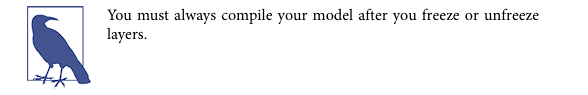

In [ ]:
# Now we can train the model for few epochs, then unfreeze the reused layers

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=5,
                           validation_split=0.2)

Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0000e+00 - loss: -4409.2896 - val_accuracy: 0.0000e+00 - val_loss: -23092.7012
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0000e+00 - loss: -22029.8477 - val_accuracy: 0.0000e+00 - val_loss: -46171.1328
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0000e+00 - loss: -39944.9062 - val_accuracy: 0.0000e+00 - val_loss: -69249.5547
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0000e+00 - loss: -57109.0078 - val_accuracy: 0.0000e+00 - val_loss: -92327.9766
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0000e+00 - loss: -75091.6641 - val_accuracy: 0.0000e+00 - val_loss: -115406.4141


In [ ]:
for layer in model_B_on_A.layers[:-1]:
  layer.trainable = True

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=1e-4) # default is 1e-2
model_B_on_A.compile(loss="mse", optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_split=0.2)

Epoch 1/16
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.0000e+00 - loss: 54.7286 - val_accuracy: 0.0000e+00 - val_loss: 64.0000
Epoch 2/16
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0000e+00 - loss: 54.6419 - val_accuracy: 0.0000e+00 - val_loss: 64.0000
Epoch 3/16
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0000e+00 - loss: 54.6707 - val_accuracy: 0.0000e+00 - val_loss: 64.0000
Epoch 4/16
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0000e+00 - loss: 54.6634 - val_accuracy: 0.0000e+00 - val_loss: 64.0000
Epoch 5/16
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0000e+00 - loss: 54.6382 - val_accuracy: 0.0000e+00 - val_loss: 64.0000
Epoch 6/16
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0000e+00 - loss: 54.4894 - val_accuracy: 0.0000e+00 - val_loss: 64.0000
Epoch 7/16
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0000e+00 - loss: 54.6594 - val_accuracy: 0.0000e+00 - val_loss: 64.0000
Epoch 8/16
300/300 ━━━━━━━━━━━━━

In [ ]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0000e+00 - loss: 51.4818


[56.5, 0.0]

 It turns out that transfer learning does not work very well with
 small dense networks, presumably because small networks learn few patterns, and
 dense networks learn very specific patterns, which are unlikely to be useful in other
 tasks. Transfer learning works best with deep convolutional neural networks, which
 tend to learn feature detectors that are much more general (especially in the lower
 layers).

## Unsupervised Pretraining

Suppose you want to tackle a complex task for which you don't have much labeled training data, but unfortunately you cannot find a model trained on a similar task. In that case you can perform **unsupervised pretraining**. Indeed, it is often cheap to gather unlabeled training examples, but expensive to label them.

Unsupervised pretraining is still a good option when you have a complex task to solve, no simliar model you can reuse, and little labeled training data but plenty of unlabeled training data.

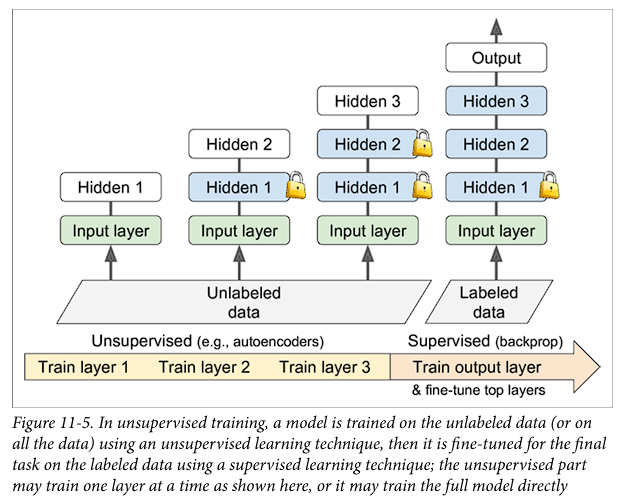

## Pretraining on an Auxiliary Task

If you do not have much labeled training data, one last option is to train a first neural network on an auxiliary task for which you can easily obtain or generate labeled training data, then reuse the lower layers of that network for your actual task. The frist neural network's lower layers will learn feature detectors that will likely be reusable by the second neural network.

For example, if you want to build a system to recognize faces, you may only have a
 few pictures of each individual—clearly not enough to train a good classifier. Gather
ing hundreds of pictures of each person would not be practical. You could, however,
 gather a lot of pictures of random people on the web and train a first neural network
 to detect whether or not two different pictures feature the same person. Such a network would learn good feature detectors for faces, so reusing its lower layers would allow you to train a good face classifier that uses little training data.

  For natural language processing (NLP) applications, you can download a corpus of
 millions of text documents and automatically generate labeled data from it. For exam
ple, you could randomly mask out some words and train a model to predict what the
 missing words are (e.g., it should predict that the missing word in the sentence “What
 ___ you saying?” is probably “are” or “were”). If you can train a model to reach good
 performance on this task, then it will already know quite a lot about language, and
 you can certainly reuse it for your actual task and fine-tune it on your labeled data

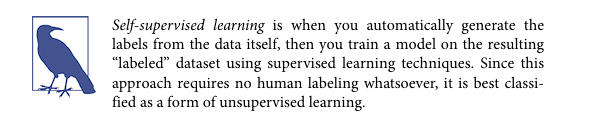

# Faster Optimizers

Training a very large deep neural network can be painfully slow. So far we have seen
 four ways to speed up training (and reach a better solution): applying a good initiali
zation strategy for the connection weights, using a good activation function, using
 Batch Normalization, and reusing parts of a pretrained network (possibly built on an
 auxiliary task or using unsupervised learning). Another huge speed boost comes from
 using a faster optimizer than the regular Gradient Descent optimizer. In this section
 we will present the most popular algorithms: momentum optimization, Nesterov
 Accelerated Gradient, AdaGrad, RMSProp, and finally Adam and Nadam
 optimization.

## Momentum Optimization

Imagine a ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity. This is the very simple idea behind **momentum optimization**. In contrast, regular Gradient Descent will simply take small, regular steps down the slope, so the algorithm will take  much more time to reach the bottom.

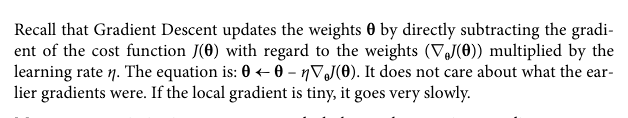

In Momentum optimization , at each iteration, it subtracts the local gradient from the *momentum vector* **m**(multiplied by the learning rate) and it updates the weights by adding this momentum vector (see the equation below).

In other words, the gradient is used for acceleration, not for speed. To simulate some sort of friction mechanizm and prevent the momentum from growing too large, the algorithm  introduces a new hyperparameter β, called the **momentum**, which must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9.

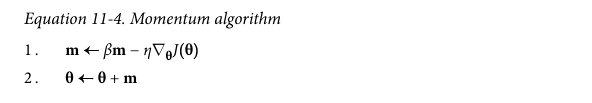

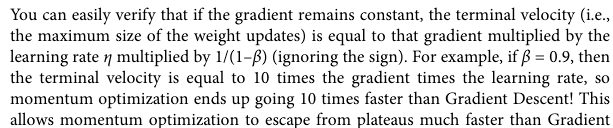

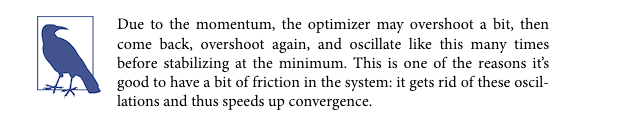

Implementing momentum optimization in Keras is a no-brainer: just use the **SGD** optimizer and set its **momentum hyperparameter**:

In [ ]:
from tensorflow import keras
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

The one drawback of momentum optimization is that it adds yet another hyperparameter to tune. However, the momentum value of 0.9 usually works well in practice and almost always goes faster than regular Gradient Descent

## Nesterov Accelearted Gradient

One small variant to momentum optimization, proposed by **Yurii Nesterov in 1983**, is almost always faster than vanilla momentum optimization. The *Nesterov Accelerated Gradient* **(NAG)** method, measures the gradient of the cost function not at the local position **ϴ** but slightly ahead in the direction of the momentum , at **ϴ + βm**

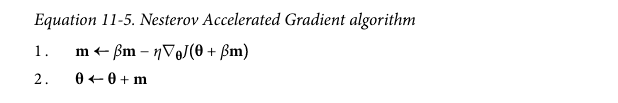

This small tweak works because in general the momentum vector will be pointing in the right direction (i.e., towards the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than the gradient at the original position, as you can see in the figure below( where ∇1 represents the gradient of the cost function measured at the starting point θ, and ∇2
represents the gradient at the point located at θ + βm).

As you can see, the NAG update ends up slightly closer to the optimum. After a while these small improvements add up and NAG ends up being significantly faster than regular momentum optimization. Moreover, note that when the momentum pushes the weights across a valley, ∇1 continues to push farther across the valley, while ∇2 pushes back toward the bottom of the valley. This helps reduce oscillations and thus NAG converges faster.

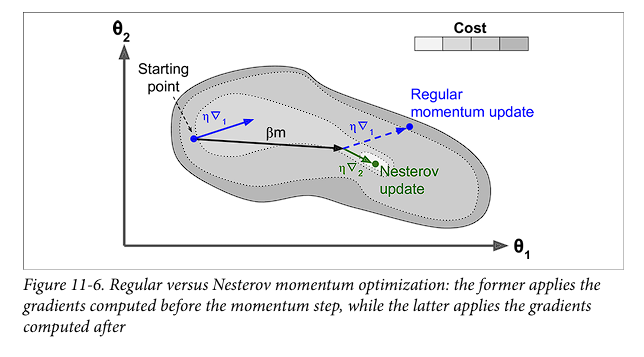

NAG is generally faster than regular momentum optimization. To use it, simply set **nesterov=True** when creating the SGD optimizer:

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

## AdaGrad

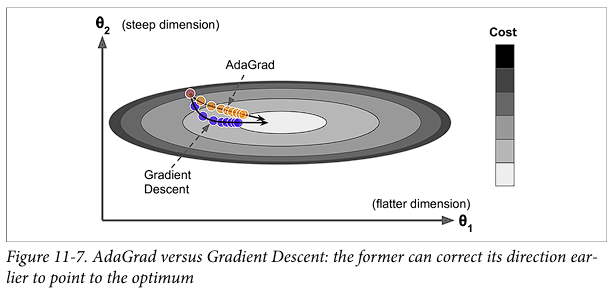

Consider the elongated bowl problem again: Gradient Descent starts by quickly going down the steepest slope, which does not point straight toward the global optimum, then it very slowly goest down to the bottom of the valley. It would be nice if the algorithm could correct its direction earlier to point a bit more toward the global optimum. The **AdaGrad algorithm** achieves this correction by scalling down the gradient vector along the steepest dimensions.

AdaGrad frequently performs well for simple quadratic problems, but it often stops too early when training neural networks. So even though Keras has an *Adagrad* optimizer, you should not use it to train deep neural networks (it may be efficient for simpler tasks such as Linear Regression, though).

## RMSProp

As we've seen. AdaGrad runs the risk of slowing down a bit too fast and never converging to the global optimum. The *RMSProp* algorithm fixes this by accumulating only the gradients from the most recent iterations ( as opposed to all the gradients since the beginning of training). It does so by using exponential decay in the first step:

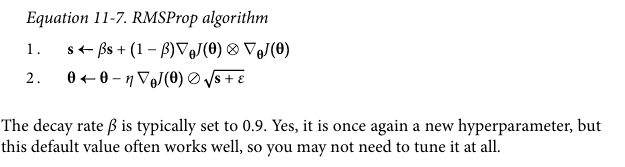

Keras has an **RMSprop** optimizer:

In [ ]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

Note that the *rho* argument corresponds to β in the equation. Except on very simple problems, this optimizer almost always performs better than AdaGrad.

Infact, it was the preffered optimization algorithm of many researchers until Adam optimization came around.

## Adam and Nadam Optimization

Adam, which stands for *adaptive moment estimation*, combines the ideas of momentum optimization and RMSProp: just like momentum optimization, it keeps track of an exponentially decaying average of past gradients; and just like RMSProps, it keeps track of an exponentially decaying average of past squared gradients.

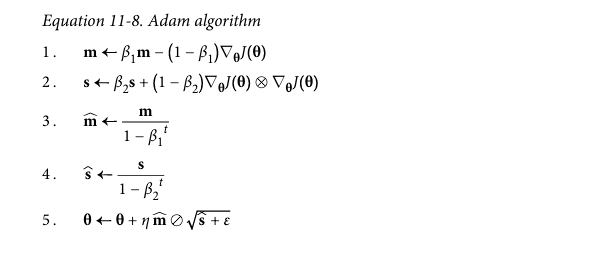

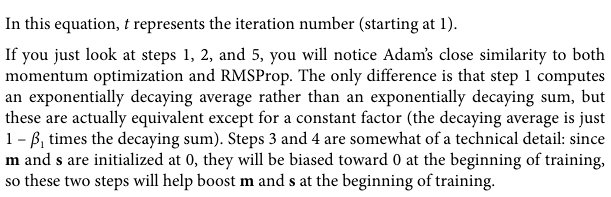

The momentum decay hyperparameter β1 is typically initialized to 0.9, while the scaling decay hyperparameter is often initialized to 0.999. As earlier, the smoothing term  ε is usually initialized to a tiny number such as 1e-7. These are the default values for the *Adam* class (to be precise, epsilon defaults to None, which tells Keras to use Keras.backend.epsilon(), which defaults to 1e-7; you can change it using Keras.backend.set_epsilon()). Here is how to create an Adam optimizer using Keras:

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

Since Adam is an adaptive learning rate algorithm. It requires less tuning of the learning rate hyperparameter  η. you can often use the default value of  η = 0.001, making Adam even easier to use than Gradient Descent.

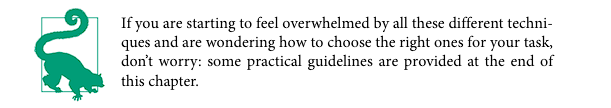

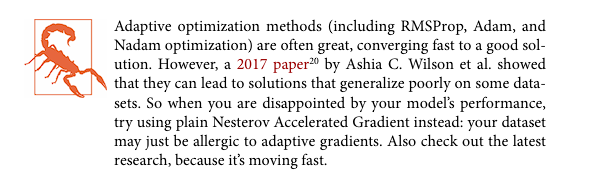

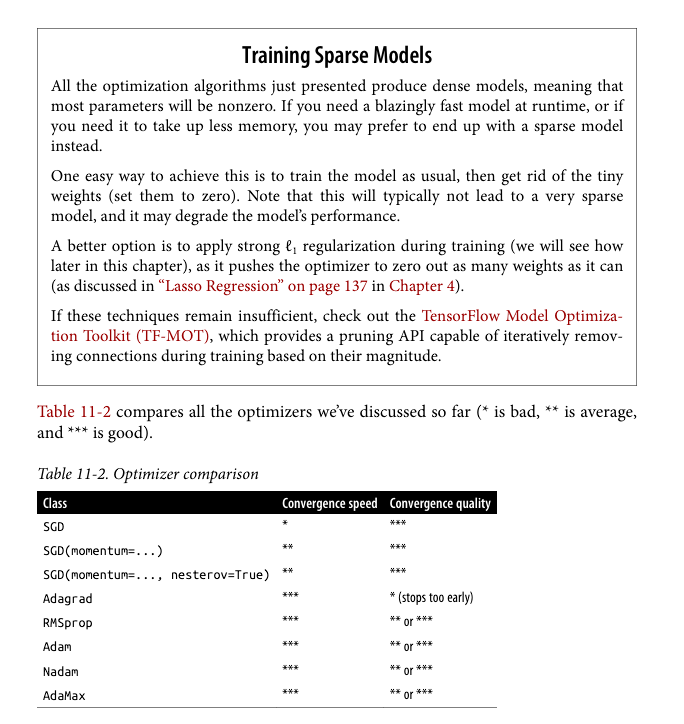

## Learning Rate Scheduling

Finding a good learning rate is very important. If you set it much too high, training may diverge. If you set it too low, training will eventually converge to the optimum, but it will take a very long time. If you set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum never really settling down. If you have limited computing budges, you may have to interrupt training before it has converged properly, yielding a suboptimal solution.

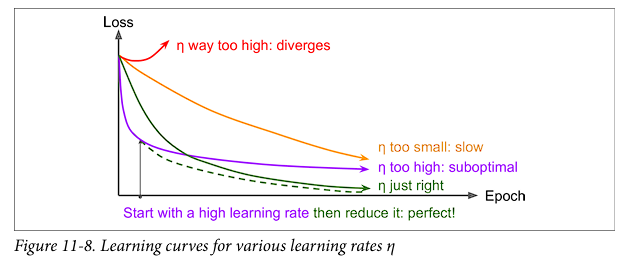

As discussed in the previous chapter, you can find a good learning rate by training the model for a few hundred iterations, exponentially increasing learning rates and then you can reinitialize your model and training it with the learning rate slightly lower than the global minimum on the learning curve.

There are many different strategies to reduce the learning rate during training. These strategies are called *learning schedules*.

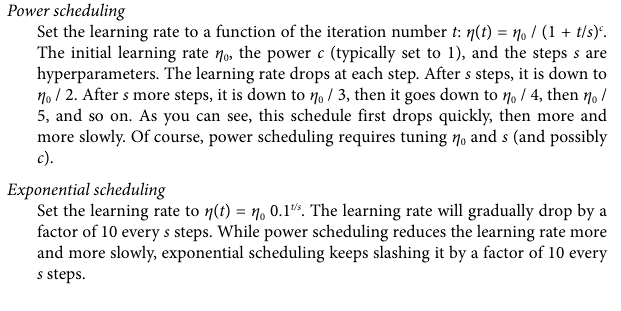

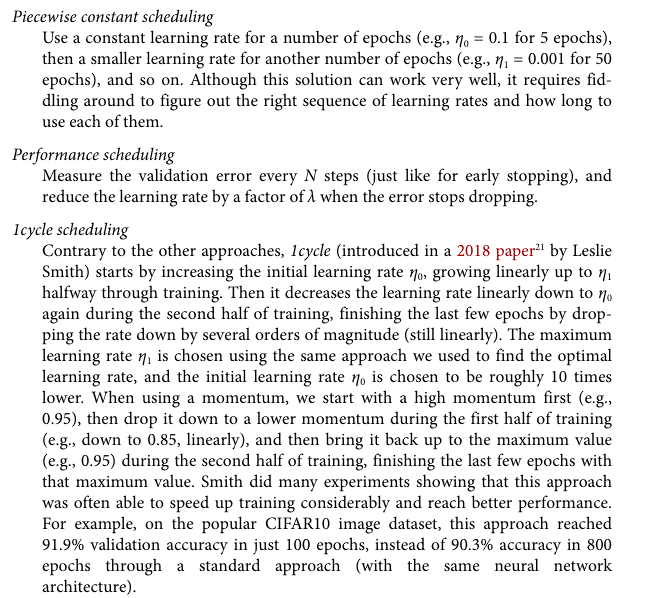

A 2013 paper by Andrew Senior et al. compared the performance of somme of the most popular learning schedules when using momentum optimization to train deep neural networks for speech recognition. The authors concluded that, in this setting both performance scheduling and exponential scheduling performed well. They favored exponential scheduling because it was easy to tune and it converged slightly faster to the optimal solution. That said, the 1cycle approach seems to perform even better.

Implementing power scheduling in Keras is the easiest option: just set the *decay* hyperparameter when creating an optimizer:

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, decay=1e-4)

The decay is the inverse of s (the number of steps it takes to divide the learning rate by one more unit), and Keras assumes that c is equals to 1.

Exponential scheduling and piecewise schedulilng are quite simple too. You first need to define a function that takes the current epoch and returns the learning rate. For example, let's implement exponential scheduling:

In [ ]:
def exponential_decay_fn(epoch):
  return 0.01*0.1**(epoch/20)

If you do not want to hardcode  η0 and s , you can create a function that returns a configured function:

In [ ]:
def exponential_decay(lr0, s):
  def exponential_decay_fn(epoch):
    return lr0 * 0.1 ** (epoch/s)
  return exponential_decay_fn

Next, create a **LearningRateScheduler** callback, giving it the schedule function, and pass this callback to the fit() method:

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, callbacks=[lr_scheduler])

The LearningRateScheduler will update the optimizer's learning_rate attribute at the beginning of each epoch.

For Piecewise constant scheduling, you can use a schedule function like the following one, then create a LearningRateSchedular callback with this function and pass it to the fit() method, just like we did for exponential scheduling:

In [ ]:
def piecewise_constant_fn(epoch):
  if epoch < 5:
    return 0.01
  elif epoch < 15:
    return 0.005
  else:
    return 0.001

For performance scheduling, use the **ReduceLROnPlateau** callback. For example, if you pass the following callback to the fit() method, it will multiply the learning rate by 0.5 whenever the best validation loss does not improve for five consecutive epochs.

In [ ]:
lr_schedular = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

Lastly, tf.keras offers an alternative way to implement learning rate scheduling: define the learning rate using one of the schedules available in **keras.optimizes.schedules**, then pass this learning rate to any optimizer. This approach updates the learning rate at each step rather than at each epoch. For example here is how to implement the same exponential schedule as the **exponential_decay_fn()** function we defined earlier:

In [ ]:
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)

This is nice and simple, plus when you save the model, the learning rate and its schedule get saved as well. This approach, however, is not part of the Keras API; it is specific to tf.keras

To sum up, exponential decay, performance scheduling, and 1cycle can considerably
 speed up convergence, so give them a try!

# Avoiding Overfitting Through Regularization

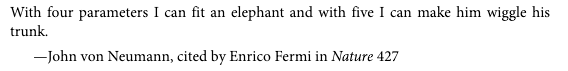

With thousands of parametes, you can fit the whole zoo. Deep neural networks typically have tens of thousands of parameters, sometime even millions. This ive them an incredible amount of freedom and means they can fit a huge variety of complex datasets. But this great flexibility also makes the network prone to overfitting the training set. We need regularization.

We already implemented one of the best regularization techniques previously, early stopping. Moreover, even though Batch Normalization was designed to solve the unstable gradients problems, it also acts like a pretty good regularizer. In this section we will examine other popular regularization techniques for nerual networks: l1 and l2 regularization, dropout, and max-norm regularization.

## L1 and L2 Regularization

You can use l2 regularization to constrain a neural network's connection weights, and l1 regularization if you want a sparse model (with  many weights equal to 0). Here is how to apply l2 regularization to a keras layers's connection weights, using a regularization factor of 0.01:

In [ ]:
layer = keras.layers.Dense(100, activation='elu',
                           kernel_initializer='he_normal',
                           kernel_regularization=keras.regularizers.l2(0.01))

The l2() function returns a regularizer that will be called at each step during training to compute the regularization loss. This is then added to the final loss. You can use ```keras.regularization.l1()``` if you want l1 regularization. If you want both l1 and l2 regularization, use ```keras.regularization.l1_l2()```

Since you will typically want to apply the same regularization to all layers in your network, as well as using the same activation function and the same initialization strategy in all hidden layers, you may find yourself repeating the same arguments. This makes the code ugly and error-prone. To avoid this, you can try refactoring your code to use loops. Another option is to use Python's ```functools.partial()``` function, which lets you create a thin wrapper for any callable, with some default argument values:

In [ ]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation='elu',
                           kernel_initializer='he_normal',
                           kernel_regularization=keras.regularization.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation='softmax', kernel_initializer="glorot_uniform")
])

## Dropout

*Dropout* is one of the most popular regularization techniques for deep neural netowrks. It was proposed in a paper by Geoffrey Hinton in 2012 and further detailed in a 2014 paper by Nitish Srivastava et al. and it has proven to be highly successful: even the state-of-the-art neural networks gets a 1-2% accuracy boost simply by adding dropout.

It is fairly simple algorithm: at every training step, every neuron (including the input neurons, but always excluding the output neurons) has a probability *p* of being temporarily "dropped out", meaning it will be entirely ignored during this training step, but it may be active during the next step.

The Hyperparameter *p* is called the **dropout rate**, and it is typically set between 10% and 50%: closer to 20-30% in RNNs and closer to 40-50% in CNNs. After training, neurons don't get dropped any more.

Neurons trained with dropout cannot co-adapt with their neighboring neurons; they have to be as useful as possible on their own. They also cannot rely excessively on just a few input neurons; they must pay attention to each of their input neurons. They end up being less sensitive to slight changes in the inputs. In the end, you get a mroe robust network that generalizes better.

Another way to understsand the power of dropout is to realize that a unique neural network is generated at each training step. Since each neuron can be either present or absent, there are a total of 2^N possible networks (where N is the total number of dropable neurons). Once you have run 10,000 training steps, you have essentially trained 10,000 different neural networks (each with just one training instance). These neural networks are obviously not independent because they share many of their weights, but they are nevertheless all different. The resulting neural network can be seen as an averaging ensemble of all these smaller neural networks.

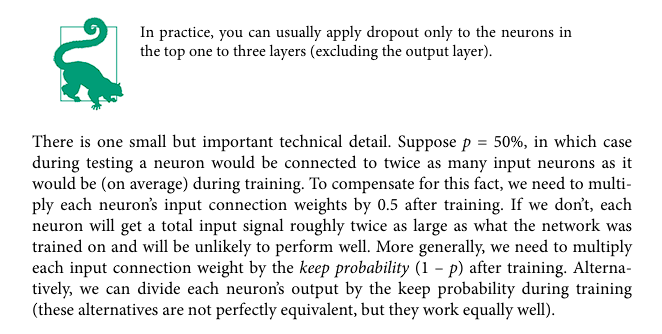

To implement dropout using Keras, you can use the ```keras.layers.Dropout.layer```. During training, it randomly drops some inputs (setting them to 0) and divides the remaining inputs by the keep probability. After training, it does nothing at all; it just passes the inputs to the next layer. THe following code applies dropout regularization before every **Dense layer**, using a dropout of 0.2

In [ ]:
model = keras.model.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers,Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers,Dropout(rate=0.2),
    keras.layers.Dense(10, activation='softmax')
])

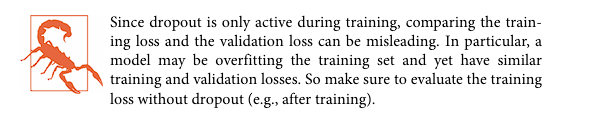

If you observe that the model is overfitting, you can increase the dropout rate. Conversely, you should try decreasing the dropout rate if the model underfits the training set.

Dropout does tend to significantly slow down convergence, but it usually results in a much better model when tuned properly. So, it is generally well worth the extra time and effort.

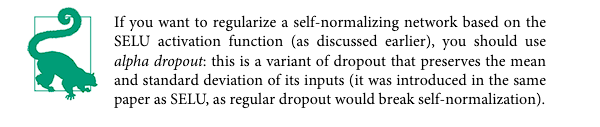

## Monte Carlo (MC) Dropout

In 2016 a paper by Yarin Gal and Zoubin Ghahramani added a few more good reasons to use dropout:

- First,  the paper established a profound connection between dropout networks (i.e., neural networks containing a Dropout layer before every weight layer) and approximate Bayesian Inference, giving dropout a solid mathematical justification.

- Second, the authors introduced a powerful technique called *MC Dropout*, which can boost the performance of any trained dropout model without haveing to retrain it or even modify it at all, provides a much better measure of the model's uncertainity, and is also amazingly simple to implement.

Below is the full implementation of MC Dropout, boosting the dropout model we trained earlier without retraining it:

In [ ]:
y_probas = np.stack([model(X_test_scaled, training=True) for sample in range(100)])
y_proba = y_probas.mean(axis=0)

We just make 100 predictions over the test set, setting *training=True* to ensure that the *Dropout* layer is active, and stack the predictions. Since dropout is active, all the predictions will be different. Recall the *predict()* returns a matrix with one row per instance and one column per class. Because there are 10,000 instances in the test set and 10 classses, this is a matrix of shape [10000, 10]. We stack 100 such matrices, so *y_probas* is an array of shape [100, 10000, 10]. Once we average over the first dimension (axis=0), we get *y_proba*, an array of shape [10000, 10], like we would get with a single prediction. That's all! Averaging over multiple predictions with dropout on gives us a **Monte Carlo estimate** that is generally more reliable than the result of a single prediction with the dropout off. For example, let's look at the model's prediction for the first instance in the Fashion MNIST test set, with dropout off:

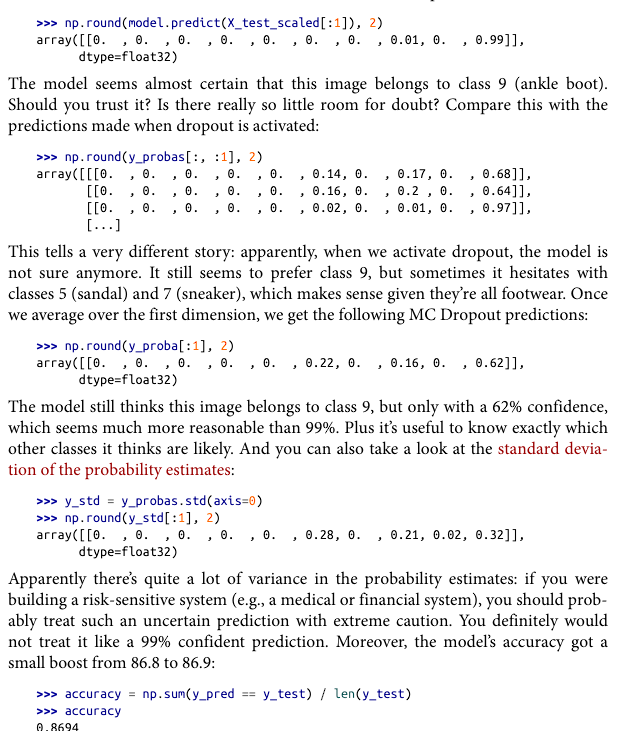

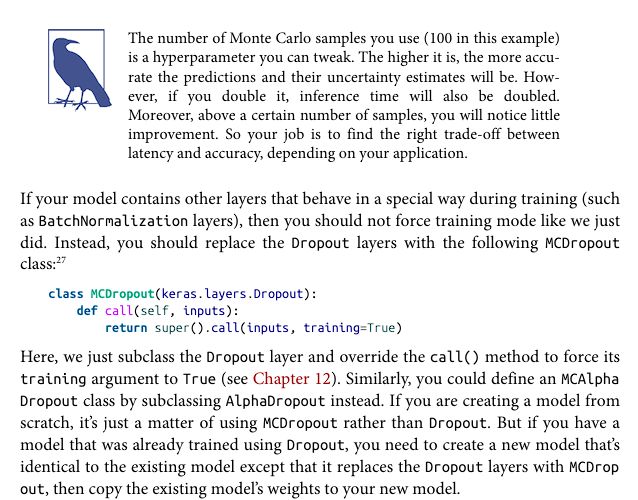

In short, MC Dropout is a fantastic technique that boosts dropout models and provides better uncertainty estimates. And of course, since it is just regular dropout during training, it also acts like a regularizer.

## Max-Norm Regularization

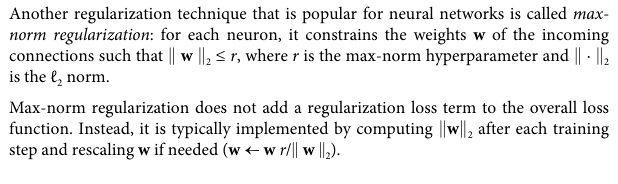

Reducing r increases the amount of regularization and helps reduce overfitting. Max-norm regularization can also help alleviate the unstable gradients problems (if you are not using Batch Normalization).

To implement max-norm regularization in *keras*, set the *kernel_constraint* argument of each hidden layer to a *max_norm()* constraint with the appropriate max value, like this:

In [ ]:
keras.layers.Dense(100, activation='elu',
                   kernel_initializer='he_normal',
                   kernel_constraint=keras.constraints.max_norm(1.))

After each training iteration, the model's fit() method will call the object returned by *max_norm()*, passing it the layer's weights and getting rescaled weights in return which then replace the layer's weights.

The *max_norm()* function has an axis argument that defaults to 0. A Dense layer usually has weights of shape [number of inputs, number of neurons], so using axis=0 means that the max-norm constraint will apply independently to each neuron's weight vector.

# Summary and Practical Guidelines

In this chapter we have covered a wide range of techniques, and you may be wondering which ones you shoud use. This depends on the task, and there is no clear consensus yet, but configuration in the table below work fine in most cases, without requiring much hyperparameter tuning. That said, please do not consider these defaults as hard rules!

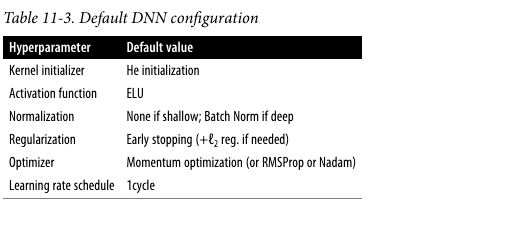

If the network is a simple stack of dense layers, then it can self-normalize, and you should use the configuration below instead.

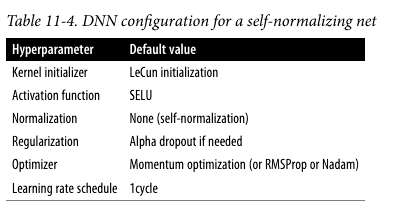

Don't forget to normalize the input features! You should also try to reuse parts of pretrained neural network if you can find one taht solves a similar problem, or use unsupervised pretraining if you have a lot of unlabeled data, or use pretraining on an auxiliary task if you have a lot of labeled data for a similar task.

While the previous guidelines should cover most cases, here are some exceptions:

- If you need a sparse model, you can use l1 regularization.

- If you need a low-latency model (one that performs lightning-fast predictions), you may need to use fewer layers, fold the Batch Normalization layers into the previous layers, and possible use a faster activation function such as leaky ReLU or just ReLU. Having a sparse model will also help.

- If you are building a risk-sensitive application, or inference latency is not very important in your application, you can use MC Dropout to boost performance and get more reliable probability estimates, along with uncertainty estimates.

